In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
import os
from nn import LightingStableDiffusion
from config import BASE_MODEL_NAME, MODEL_NAME, CHECKPOINTS_DIR
from diffusers import (
    StableDiffusionPipeline,
    DiffusionPipeline,
    StableDiffusionInpaintPipeline,
)
from config import DEVICE, BASE_MODEL_NAME


In [9]:

# load the pipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to(
    DEVICE
)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

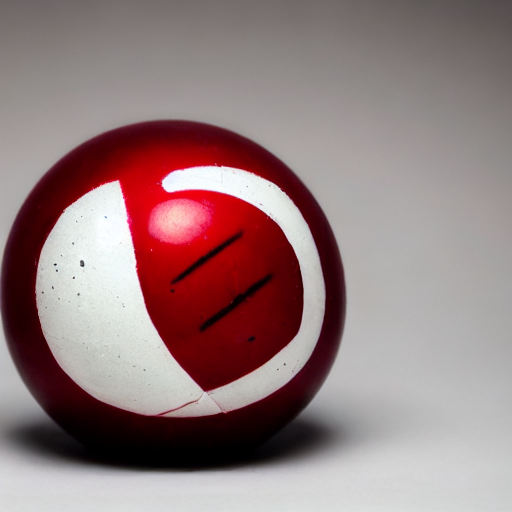

In [10]:
# let's download an initial image
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

# print("Downloading images...")
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image.thumbnail((762, 728))

# print("Generating images...")
prompt = "a red and white ball with an angry look on its face"

# images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
images = pipe(
    prompt=prompt,
).images
images[0]

In [8]:
# img1 = Image.open('wro.png').convert("RGB")
img2 = Image.open('ams.png').convert("RGB")
# img1.thumbnail((100, 100))
img2.thumbnail((700, 700))

In [9]:
i = pipe(prompt='Map of village', image=img2, strength=0.75, guidance_scale=7.5).images[0].save('test.png')
i

100%|██████████| 37/37 [00:15<00:00,  2.34it/s]


In [4]:

content_img_path = 'data/wro.png'
style_img_path = 'data/ams.png'

In [5]:
from PIL import Image
import torchvision.transforms as transfroms


trans = transfroms.Compose([
    transfroms.PILToTensor(),
    transfroms.Resize((500, 1000))
])

content_image = Image.open(content_img_path).convert("RGB")
style_image = Image.open(style_img_path).convert("RGB")

content_image.thumbnail((400, 200))
style_image.thumbnail((400, 200))

In [8]:
from guertena import style_transfer

result = style_transfer(style_image, content_image, num_steps=1000)

/home/marcin/Documents/mgr/semestr_II/nlp/nlp_l2/nlp_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/marcin/Documents/mgr/semestr_II/nlp/nlp_l2/nlp_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


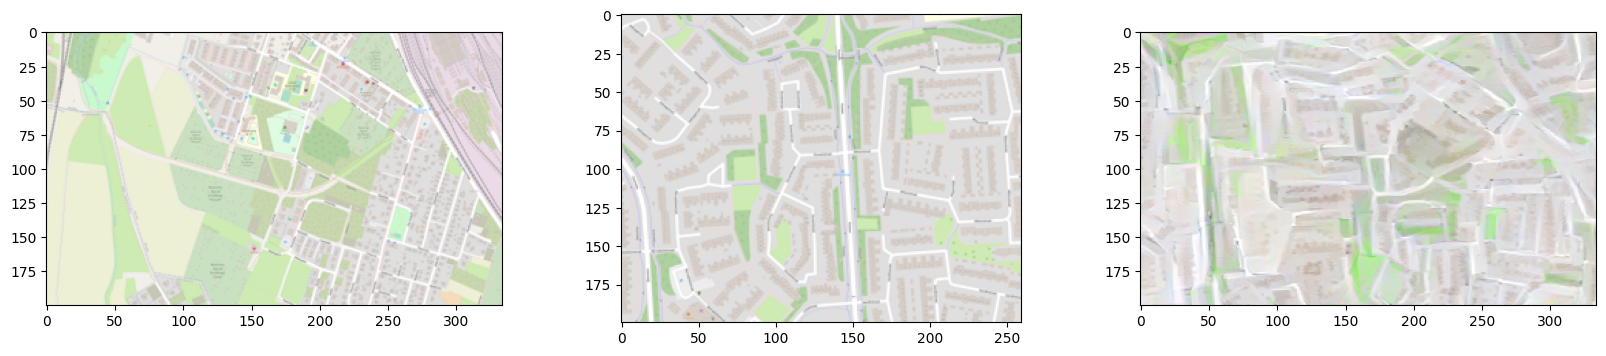

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))

ax1.imshow(content_image)
ax2.imshow(style_image)
ax3.imshow(result)

plt.show()

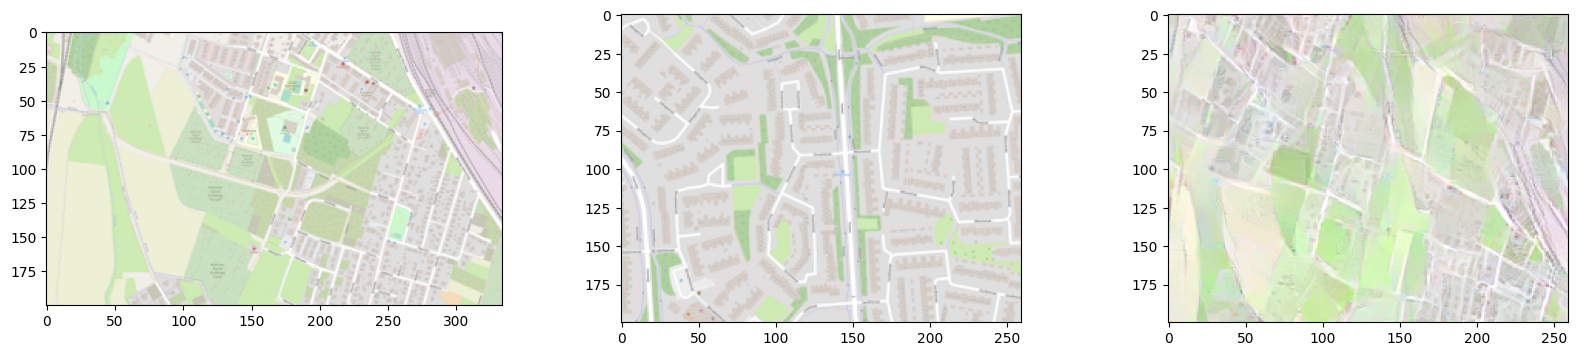

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))

ax1.imshow(content_image)
ax2.imshow(style_image)
ax3.imshow(result)

plt.show()

100%|██████████| 40/40 [00:04<00:00,  8.83it/s]


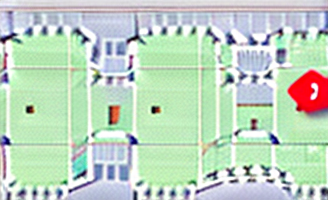

In [10]:
from diffusers import StableDiffusionImg2ImgPipeline

pipeline = StableDiffusionImg2ImgPipeline.from_pretrained('stabilityai/stable-diffusion-2-1-base')

pipeline = pipeline.to(DEVICE)
pipeline(prompt='Replace green area in left part of map with residential area', image=content_image).images[0]

In [ ]:
model = LightingStableDiffusion.load_from_checkpoint(
        os.path.join(CHECKPOINTS_DIR, f'{MODEL_NAME}.ckpt'), model_name=BASE_MODEL_NAME
    )
model.save_pipeline(os.path.join(CHECKPOINTS_DIR, f'{MODEL_NAME}_pipeline'))

In [2]:
prompt = "Map of area containing: 1 building yes 2 landuse farmlands 1 landuse residential 1 natural grassland 1 natural scrub ."
pipe = StableDiffusionPipeline.from_pretrained('OFA-Sys/small-stable-diffusion-v0').to(DEVICE)

The config attributes {'predict_epsilon': True} were passed to DPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/50 [00:00<?, ?it/s]

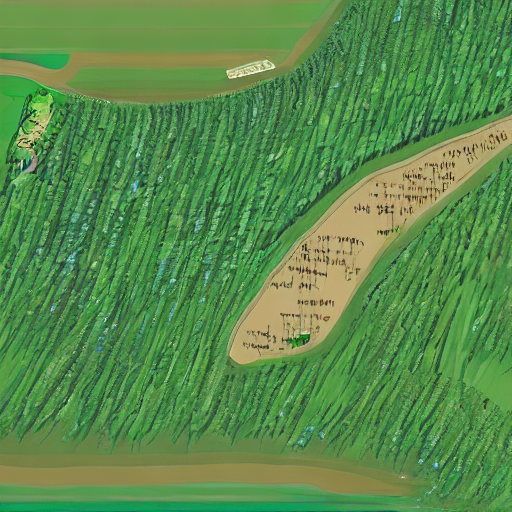

In [3]:
pipe(prompt=prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

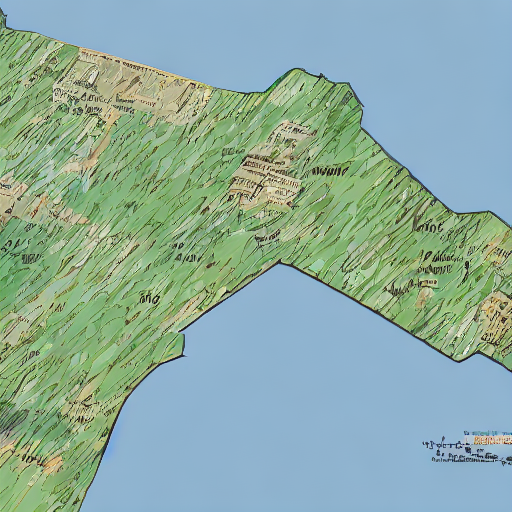

In [3]:
pipe_finetuned = StableDiffusionPipeline.from_pretrained('../models/stable_wroclaw_pipeline', safety_checker=None).to(DEVICE)
pipe_finetuned(prompt=prompt).images[0]

In [2]:
prompt = "Map of area containing: 1 building yes ."
pipe = StableDiffusionPipeline.from_pretrained('../models/stable_wroclaw_test_pipeline', safety_checker=None).to(DEVICE)

The config attributes {'predict_epsilon': True} were passed to DPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

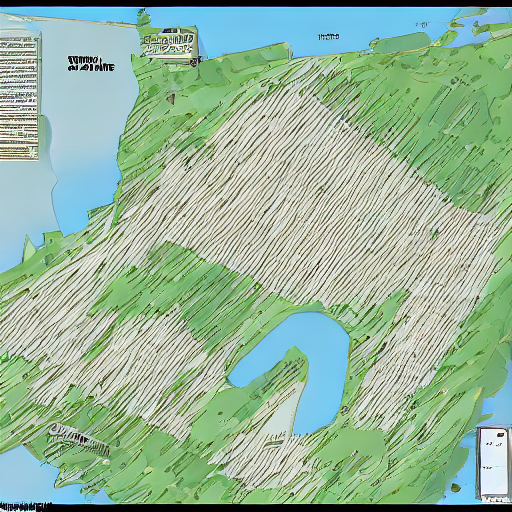

In [4]:
pipe(prompt=prompt).images[0]

In [3]:
import torch.nn as nn

unet = pipe.unet
for name, param in unet.named_parameters():
    if len(param.shape) >= 2:
        nn.init.kaiming_normal_(param.data)
    else:
        if "bias" in name:
            nn.init.zeros_(param.data)
        else:
            nn.init.ones_(param.data)

  0%|          | 0/50 [00:00<?, ?it/s]

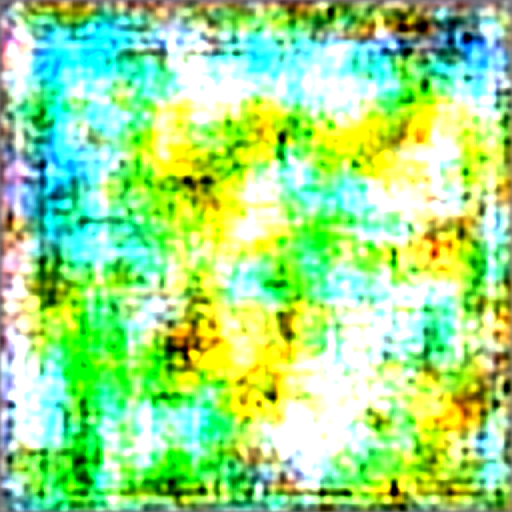

In [4]:
pipe(prompt=prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

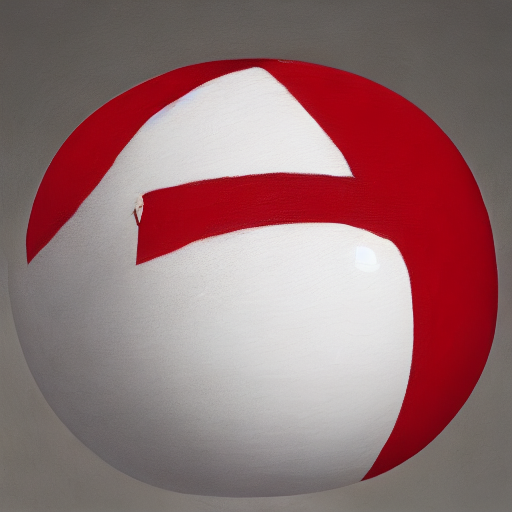

In [11]:
pipe_finetuned(prompt="a red and white ball with an angry look on its face").images[0]

In [6]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("OFA-Sys/small-stable-diffusion-v0", subfolder="vae")

In [7]:
from osm_dataset import TextToImageDataset
from config import DATA_DIR

ds = TextToImageDataset(DATA_DIR)

Resolving data files:   0%|          | 0/2145 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/marcin/.cache/huggingface/datasets/imagefolder/Wrocław, PL-16adbde1af182d57/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/marcin/.cache/huggingface/datasets/imagefolder/Wrocław, PL-16adbde1af182d57/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-954ae8540c1d54bd.arrow


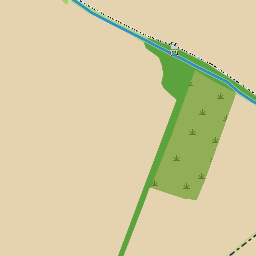

In [10]:
import torchvision.transforms.functional as ft



In [17]:
img.unsqueeze(0).shape

torch.Size([1, 3, 256, 256])

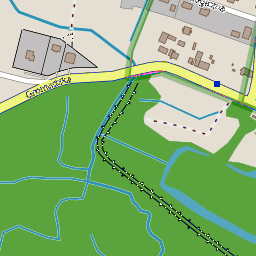

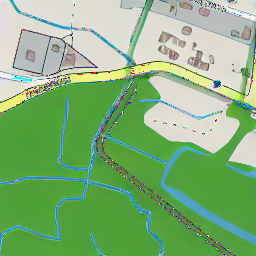

In [30]:
img = ds[110][0]
display(ft.to_pil_image(img))
with torch.no_grad():
    encoded = vae(img.unsqueeze(0))

# decoded = vae.decode(encoded)
ft.to_pil_image(encoded.sample.squeeze())